#Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from time import time
from copy import copy

In [3]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

def pairwise(iterable):
  a = iter(iterable)
  return zip(a, a)

In [9]:
class Chromosome:
  def __init__(self, length, array=None): #if array is None it should be initialized with random binary vector
    if array is None:
      self._array = np.random.randint(2, size=length)
    else:
      self._array = array
    self._length = length

  def decode(self, lower_bound: int, upper_bound: int, aoi: Tuple[float, float]) -> float:
      bits = upper_bound - lower_bound
      encoded_value = 0
      for i in range(bits):
        encoded_value += self._array[lower_bound+i].item()*pow(2, bits-i-1)
      return min_max_norm(encoded_value, 0, pow(2, bits-1), *aoi)

  def mutation(self, probability: float) -> None:
    if np.random.uniform(0, 1) < probability:
      gene_index = np.random.randint(0, self._length)
      self._array[gene_index] = int(not(self._array[gene_index]))

  def crossover(self, other: 'Chromosome') -> Tuple['Chromosome', 'Chromosome']:
    assert self._length == other._length

    crossover_index = np.random.randint(0, self._length)
    first_chromosome_array = np.concatenate((self._array[:crossover_index], other._array[crossover_index:]))
    second_chromosome_array = np.concatenate((other._array[:crossover_index], self._array[crossover_index:]))

    child1 = Chromosome(self._length, first_chromosome_array)
    child2 = Chromosome(self._length, second_chromosome_array)
    return child1, child2

In [5]:
class GeneticAlgorithm:
  def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=1000,
               tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30):
    
    assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
    self._chromosome_lengths = chromosome_length
    self._obj_func_num_args = obj_func_num_args
    self._bits_per_arg = int(chromosome_length / obj_func_num_args)
    self._objective_function = objective_function
    self._aoi = aoi
    self._tournament_size = tournament_size
    self._mutation_probability = mutation_probability
    self._crossover_probability = crossover_probability
    self._num_steps = num_steps
    self._population_size = population_size
    
    self._best_chromosomes = []
    self._trace = []
      
  @property
  def trace(self):
    return self._trace
  
  @property
  def best_chromosomes(self):
    return self._best_chromosomes

  def retrieve_obj_func_args(self, chromosome: 'Chromosome') -> np.ndarray[float]:
    arguments = []
    for i in range(self._obj_func_num_args):
      value = float(chromosome.decode(i*self._bits_per_arg, (i+1)*self._bits_per_arg, self._aoi))
      arguments.append(value)
    return np.array(arguments)

  def eval_objective_func(self, chromosome: 'Chromosome') -> float:
    return self._objective_function(*self.retrieve_obj_func_args(chromosome))

  def tournament_selection_step(self, population: np.ndarray['Chromosome']) -> 'Chromosome':
    chosen_individuals = np.random.choice(population, self._tournament_size)
    evaluations = [self.eval_objective_func(individual) for individual in chosen_individuals]
    winner = evaluations.index(min(evaluations))
    return chosen_individuals[winner]
  
  def tournament_selection(self, population: np.ndarray['Chromosome']) -> np.ndarray['Chromosome']:
    temporary_generation = []
    while len(temporary_generation) < self._population_size:
      # Select individuals to temporary generation using tournament selection and add them to the temporary generation
      temporary_generation.append(self.tournament_selection_step(population))
    return np.array(temporary_generation)

  def reproduce(self, population: np.ndarray['Chromosome']) -> np.ndarray['Chromosome']:
    # Select individuals from current population using tournament selection
    return self.tournament_selection(population)
  
  def crossover_and_mutate(self, population: np.ndarray['Chromosome']) -> np.ndarray['Chromosome']:
    new_generation = []
    
    for parent1, parent2 in pairwise(population):
      # Crossover parents with given probability, otherwise move them to the next generation
      if np.random.uniform(0, 1) < self._crossover_probability:
        child1, child2 = parent1.crossover(parent2)
        new_generation += [child1, child2]
      else:
        new_generation += [parent1, parent2]

    # Mutate new generation with given probability
    for individual in new_generation:
      individual.mutation(self._mutation_probability)

    return np.array(new_generation)

  def find_best(self, population, evaluations) -> Tuple['Chromosome', float]:
    best_evaluation = min(evaluations)
    best_evaluation_index = evaluations.index(best_evaluation)
    best_individual = population[best_evaluation_index]
    return best_individual, best_evaluation

  def plot_func(self, trace: np.array, x_range: np.ndarray=None, y_range: np.ndarray=None) -> None:
    if x_range is None:
      X = np.arange(-1, 1, 0.05)
    else:
      X = x_range
    
    if y_range is None:
      Y = np.arange(-1, 1, 0.05)
    else:
      Y = y_range
    
    X, Y = np.meshgrid(X, Y)
    Z = self._objective_function(X, Y)
    plt.figure()
    plt.contour(X, Y, Z, 10)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
    plt.show()

  def run(self, optimum_arguments=None, verbose=0, plot=False, plot_ranges=None) -> None:
    # Initialize the population and then evaluate it
    population = [Chromosome(self._chromosome_lengths) for _ in range(self._population_size)]
    evaluations = [self.eval_objective_func(individual) for individual in population]
    
    # Select best individual and return it with its evaluation
    best_individual, best_evaluation = self.find_best(population, evaluations)
    
    # Initialize trace with best individual
    self._trace = []
    self._trace.append(self.retrieve_obj_func_args(best_individual))
    self._best_chromosomes.append({'chromosome': best_individual, 'arguments': self.retrieve_obj_func_args(best_individual), 'obj_func_value': best_evaluation})
    if verbose != 0:
      if optimum_arguments is None:
        print(f"Initial best individual parameters:\tArguments: {np.array2string(self.retrieve_obj_func_args(best_individual), precision=3, floatmode='fixed')}\tEval: {self.eval_objective_func(best_individual): .3e}")
      else:
        print(f"Initial best individual parameters:\tArguments: {np.array2string(self.retrieve_obj_func_args(best_individual), precision=3, floatmode='fixed')}\tEval: {self.eval_objective_func(best_individual): .3e}\tError: {abs(self._objective_function(*optimum_arguments) - self.eval_objective_func(best_individual)): .3e}")
    
    for i in range(self._num_steps):
      start_time = time()
      # Reproduction step, returning temporary generation
      temporary_generation = self.reproduce(population)
      
      # Crossover and mutate the temporary generation
      mutants = self.crossover_and_mutate(temporary_generation)
      
      # Evaluate mutants and select best individual among them
      evaluations = [self.eval_objective_func(individual) for individual in mutants]
      step_best_individual, step_best_evaluation = self.find_best(mutants, evaluations)
      
      if step_best_evaluation <= best_evaluation:
        best_evaluation = copy(step_best_evaluation)
        best_individual = copy(step_best_individual)
          
      # Update trace with the best individual from current step
      self._trace.append(self.retrieve_obj_func_args(step_best_individual))
      self._best_chromosomes.append({'chromosome': step_best_individual, 'arguments': self.retrieve_obj_func_args(step_best_individual), 'obj_func_value': step_best_evaluation})
      
      # Assign mutant generation as latest generation for next step
      population = mutants
      end_time = time()
      
      if verbose == 1:
        if optimum_arguments is None:
          print(f"Step: {i:<3}\tBest individual parameters:\tArguments: {np.array2string(self.retrieve_obj_func_args(best_individual), precision=3, floatmode='fixed')}\tEval: {self.eval_objective_func(best_individual): .3e}")
        else:
          print(f"Step: {i:<3}\tBest individual parameters:\tArguments: {np.array2string(self.retrieve_obj_func_args(best_individual), precision=3, floatmode='fixed')}\tEval: {self.eval_objective_func(best_individual): .3e}\tError: {abs(self._objective_function(*optimum_arguments) - self.eval_objective_func(best_individual)): .3e}")
      elif verbose == 2:
        if optimum_arguments is None:
          print(f"Step: {i:<3}\tBest individual parameters:\tArguments: {np.array2string(self.retrieve_obj_func_args(best_individual), precision=3, floatmode='fixed')}\tEval: {self.eval_objective_func(best_individual): .3e}\tStep executed in {end_time-start_time:<.4e} [s]")
        else:
          print(f"Step: {i:<3}\tBest individual parameters:\tArguments: {np.array2string(self.retrieve_obj_func_args(best_individual), precision=3, floatmode='fixed')}\tEval: {self.eval_objective_func(best_individual): .3e}\tStep executed in {end_time-start_time:<.4e} [s]\tError: {abs(self._objective_function(*optimum_arguments) - self.eval_objective_func(best_individual)): .3e}")
      

    if plot:
      if plot_ranges is None:
        self.plot_func(self._trace)
      else:
        self.plot_func(self._trace, *plot_ranges)

# Pierwsza funkcja

\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}

In [6]:
f = lambda x, y: 1.5 - np.exp(-x**2-y**2) - 0.5*np.exp(-(x-1)**2-(y+2)**2)
X = np.arange(-2, 3, 0.05)
Y = np.arange(-4, 2, 0.05)

In [7]:
print(f"Global minimum at (1,3)\tValue at global minimum: {f(0, 0): .5e}")

Global minimum at (1,3)	Value at global minimum:  4.96631e-01


Initial best individual parameters:	Arguments: [-0.553  0.128]	Eval:  7.749e-01	Error:  2.783e-01
Step: 0  	Best individual parameters:	Arguments: [-0.393  0.368]	Eval:  7.516e-01	Step executed in 1.3719e+00 [s]	Error:  2.550e-01
Step: 1  	Best individual parameters:	Arguments: [-0.040  0.004]	Eval:  4.985e-01	Step executed in 1.2020e-01 [s]	Error:  1.899e-03
Step: 2  	Best individual parameters:	Arguments: [-0.040  0.004]	Eval:  4.985e-01	Step executed in 1.1812e-01 [s]	Error:  1.899e-03
Step: 3  	Best individual parameters:	Arguments: [-0.040  0.004]	Eval:  4.985e-01	Step executed in 1.2217e-01 [s]	Error:  1.899e-03
Step: 4  	Best individual parameters:	Arguments: [-0.040  0.004]	Eval:  4.985e-01	Step executed in 1.2300e-01 [s]	Error:  1.899e-03
Step: 5  	Best individual parameters:	Arguments: [0.002 0.002]	Eval:  4.966e-01	Step executed in 1.1948e-01 [s]	Error:  1.756e-05
Step: 6  	Best individual parameters:	Arguments: [0.002 0.002]	Eval:  4.966e-01	Step executed in 1.2562e-01 [s]	

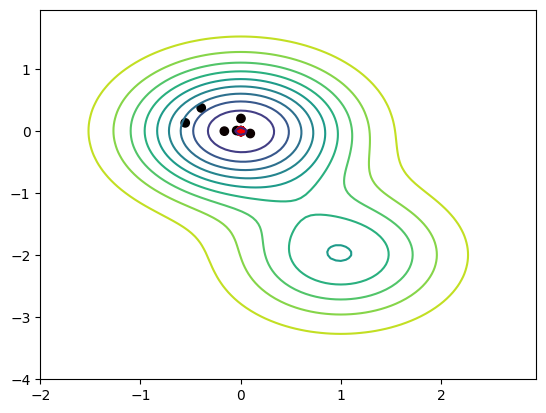

In [10]:
algorithm = GeneticAlgorithm(32, 2, f, [-5, 5], population_size=1000, num_steps=100)
algorithm.run(optimum_arguments=[0, 0], verbose=2, plot=True, plot_ranges=[X, Y])

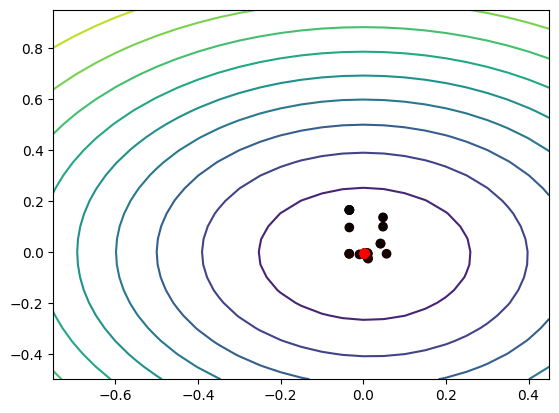

In [245]:
X_narrow = np.arange(-0.75, 0.5, 0.05)
Y_narrow = np.arange(-0.5, 1, 0.05)
algorithm.plot_func(algorithm.trace, X_narrow, Y_narrow)

### Większa populacja

Initial best individual parameters:	Arguments: [0.061 0.007]	Eval:  5.001e-01	Error:  3.484e-03
Step: 0  	Best individual parameters:	Arguments: [0.061 0.007]	Eval:  5.001e-01	Step executed in 9.9198e-01 [s]	Error:  3.476e-03
Step: 1  	Best individual parameters:	Arguments: [0.061 0.007]	Eval:  5.001e-01	Step executed in 6.4405e-02 [s]	Error:  3.449e-03
Step: 2  	Best individual parameters:	Arguments: [-0.003  0.004]	Eval:  4.967e-01	Step executed in 4.4913e-02 [s]	Error:  1.011e-04
Step: 3  	Best individual parameters:	Arguments: [-0.003  0.004]	Eval:  4.967e-01	Step executed in 4.4319e-02 [s]	Error:  1.011e-04
Step: 4  	Best individual parameters:	Arguments: [-0.003  0.004]	Eval:  4.967e-01	Step executed in 4.7866e-02 [s]	Error:  1.011e-04
Step: 5  	Best individual parameters:	Arguments: [-0.003  0.004]	Eval:  4.967e-01	Step executed in 4.3858e-02 [s]	Error:  1.011e-04
Step: 6  	Best individual parameters:	Arguments: [-0.003  0.004]	Eval:  4.967e-01	Step executed in 4.6136e-02 [s]	Er

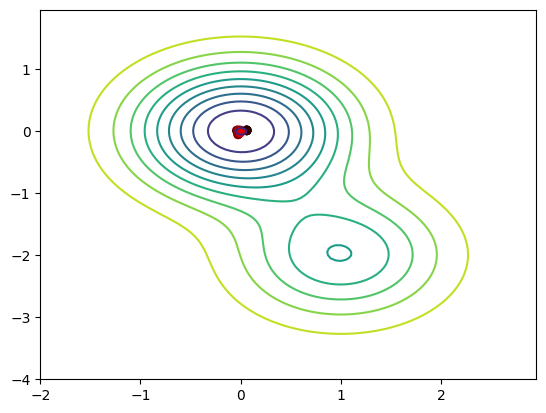

In [216]:
algorithm3 = GeneticAlgorithm(32, 2, f, [-5, 5], population_size=1000, num_steps=10)
algorithm3.run(optimum_arguments=[0, 0], verbose=2, plot=True, plot_ranges=[X, Y])

### Mniejsza długość / wielkość chromosomu dla funkcji $f(x)$

Initial best individual parameters:	Arguments: [0.000 0.000]	Eval:  4.966e-01	Error:  0.000e+00
Step: 0  	Best individual parameters:	Arguments: [0.000 0.000]	Eval:  4.966e-01	Step executed in 8.8204e-01 [s]	Error:  0.000e+00


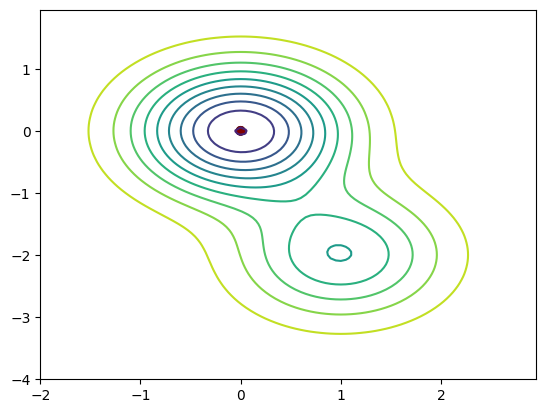

In [244]:
algorithm4 = GeneticAlgorithm(4, 2, f, [-5, 5], population_size=1000, num_steps=1)
algorithm4.run(optimum_arguments=[0, 0], verbose=2, plot=True, plot_ranges=[X, Y])

### Mniejsza populacja - prawdopodobieństwo utknięcia w minimum lokalnym

Initial best individual parameters:	Arguments: [ 0.368 -3.070]	Eval:  1.393e+00	Error:  8.966e-01
Step: 0  	Best individual parameters:	Arguments: [ 0.368 -3.070]	Eval:  1.393e+00	Step executed in 7.3910e-04 [s]	Error:  8.966e-01
Step: 1  	Best individual parameters:	Arguments: [ 0.368 -3.070]	Eval:  1.393e+00	Step executed in 1.0462e-03 [s]	Error:  8.966e-01
Step: 2  	Best individual parameters:	Arguments: [ 0.368 -3.070]	Eval:  1.393e+00	Step executed in 6.9904e-04 [s]	Error:  8.966e-01
Step: 3  	Best individual parameters:	Arguments: [ 0.368 -3.070]	Eval:  1.393e+00	Step executed in 6.4516e-04 [s]	Error:  8.966e-01
Step: 4  	Best individual parameters:	Arguments: [ 0.368 -3.070]	Eval:  1.393e+00	Step executed in 9.1910e-04 [s]	Error:  8.966e-01
Step: 5  	Best individual parameters:	Arguments: [ 0.368 -3.070]	Eval:  1.393e+00	Step executed in 5.5933e-04 [s]	Error:  8.966e-01
Step: 6  	Best individual parameters:	Arguments: [ 0.368 -3.070]	Eval:  1.393e+00	Step executed in 6.4588e-04 

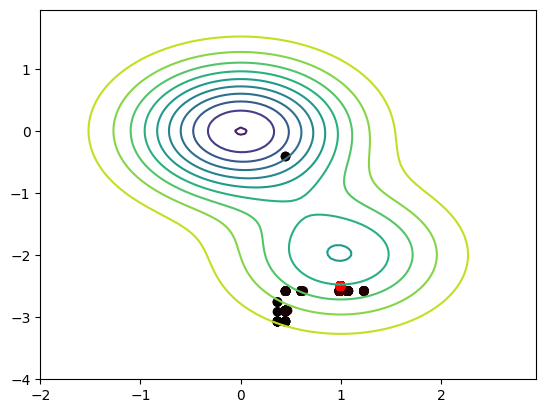

In [224]:
algorithm5 = GeneticAlgorithm(32, 2, f, [-5, 5], population_size=10, num_steps=1000)
algorithm5.run(optimum_arguments=[0, 0], verbose=2, plot=True, plot_ranges=[X, Y])

### Większe prawdopodobieństwo krzyżowania

Initial best individual parameters:	Arguments: [ 1.556 -1.659]	Eval:  1.168e+00	Error:  6.711e-01
Step: 0  	Best individual parameters:	Arguments: [ 1.517 -1.643]	Eval:  1.156e+00	Step executed in 8.5306e-04 [s]	Error:  6.598e-01
Step: 1  	Best individual parameters:	Arguments: [ 1.517 -1.643]	Eval:  1.156e+00	Step executed in 6.1607e-04 [s]	Error:  6.598e-01
Step: 2  	Best individual parameters:	Arguments: [ 1.517 -1.643]	Eval:  1.156e+00	Step executed in 5.4097e-04 [s]	Error:  6.598e-01
Step: 3  	Best individual parameters:	Arguments: [ 1.517 -1.643]	Eval:  1.156e+00	Step executed in 4.9996e-04 [s]	Error:  6.598e-01
Step: 4  	Best individual parameters:	Arguments: [ 1.517 -1.643]	Eval:  1.156e+00	Step executed in 5.4789e-04 [s]	Error:  6.598e-01
Step: 5  	Best individual parameters:	Arguments: [ 1.517 -1.643]	Eval:  1.156e+00	Step executed in 5.1212e-04 [s]	Error:  6.598e-01
Step: 6  	Best individual parameters:	Arguments: [ 1.517 -1.643]	Eval:  1.156e+00	Step executed in 5.5194e-04 

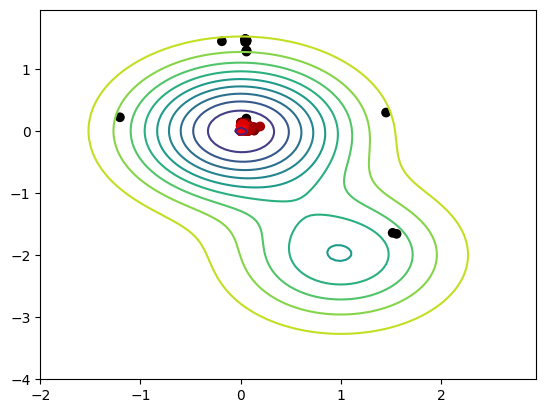

In [225]:
algorithm6 = GeneticAlgorithm(32, 2, f, [-5, 5], population_size=10, num_steps=1000, mutation_probability=0.6)
algorithm6.run(optimum_arguments=[0, 0], verbose=2, plot=True, plot_ranges=[X, Y])

### Większa długość / wielkość chromosomu

Initial best individual parameters:	Arguments: [ 1.214 -0.650]	Eval:  1.273e+00	Error:  7.762e-01
Step: 0  	Best individual parameters:	Arguments: [ 1.214 -0.650]	Eval:  1.273e+00	Step executed in 3.1085e+00 [s]	Error:  7.762e-01
Step: 1  	Best individual parameters:	Arguments: [ 1.214 -0.650]	Eval:  1.273e+00	Step executed in 5.2684e-01 [s]	Error:  7.762e-01
Step: 2  	Best individual parameters:	Arguments: [ 1.214 -0.650]	Eval:  1.273e+00	Step executed in 4.9384e-01 [s]	Error:  7.762e-01
Step: 3  	Best individual parameters:	Arguments: [-0.424 -0.951]	Eval:  1.140e+00	Step executed in 4.7399e-01 [s]	Error:  6.435e-01
Step: 4  	Best individual parameters:	Arguments: [-0.424 -0.951]	Eval:  1.140e+00	Step executed in 4.8307e-01 [s]	Error:  6.435e-01
Step: 5  	Best individual parameters:	Arguments: [ 0.421 -1.698]	Eval:  1.127e+00	Step executed in 4.7372e-01 [s]	Error:  6.303e-01
Step: 6  	Best individual parameters:	Arguments: [ 0.421 -1.698]	Eval:  1.127e+00	Step executed in 4.7914e-01 

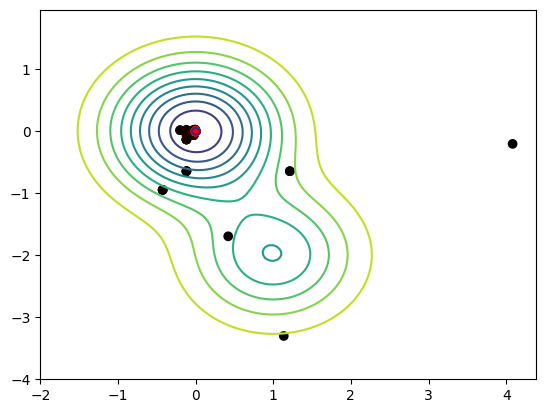

In [231]:
algorithm6 = GeneticAlgorithm(256, 2, f, [-100, 100], population_size=2000, num_steps=200)
algorithm6.run(optimum_arguments=[0, 0], verbose=2, plot=True, plot_ranges=[X, Y])

In [154]:
g = lambda x, y: (x + 2*y - 7)**2 + (2*x + y - 5)**2
XG = np.arange(-10, 10, 0.05)
YG = np.arange(-10, 10, 0.05)

In [208]:
print(f"Global minimum at (1,3)\tValue at global minimum: {g(1,3)}")

Global minimum at (1,3)	Value at global minimum: 0


Initial best individual parameters:	Arguments: [1.132 2.907]	Eval:  3.216e-02	Error:  3.216e-02
Step: 0  	Best individual parameters:	Arguments: [1.132 2.907]	Eval:  3.216e-02	Step executed in 9.3729e-01 [s]	Error:  3.216e-02
Step: 1  	Best individual parameters:	Arguments: [1.132 2.907]	Eval:  3.216e-02	Step executed in 6.1165e-02 [s]	Error:  3.216e-02
Step: 2  	Best individual parameters:	Arguments: [1.132 2.907]	Eval:  3.216e-02	Step executed in 5.2254e-02 [s]	Error:  3.216e-02
Step: 3  	Best individual parameters:	Arguments: [1.132 2.907]	Eval:  3.216e-02	Step executed in 4.9711e-02 [s]	Error:  3.216e-02
Step: 4  	Best individual parameters:	Arguments: [0.938 3.030]	Eval:  8.930e-03	Step executed in 4.9964e-02 [s]	Error:  8.930e-03
Step: 5  	Best individual parameters:	Arguments: [0.938 3.030]	Eval:  8.926e-03	Step executed in 5.2852e-02 [s]	Error:  8.926e-03
Step: 6  	Best individual parameters:	Arguments: [1.009 2.962]	Eval:  4.759e-03	Step executed in 5.2614e-02 [s]	Error:  4.75

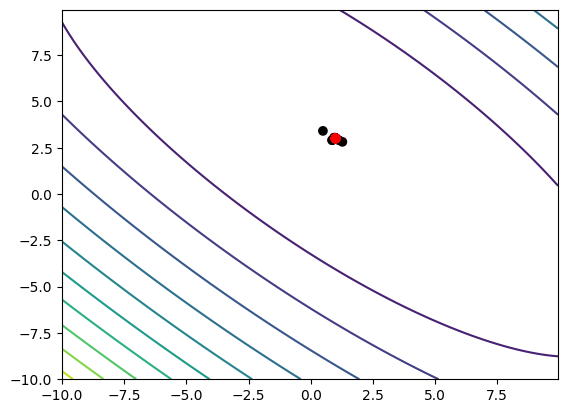

In [206]:
algorithm2 = GeneticAlgorithm(48, 2, g, [-10, 10], population_size=1000, num_steps=100, mutation_probability=0.25)
algorithm2.run(plot=True, optimum_arguments=[1, 3], verbose=2, plot_ranges=[XG, YG])

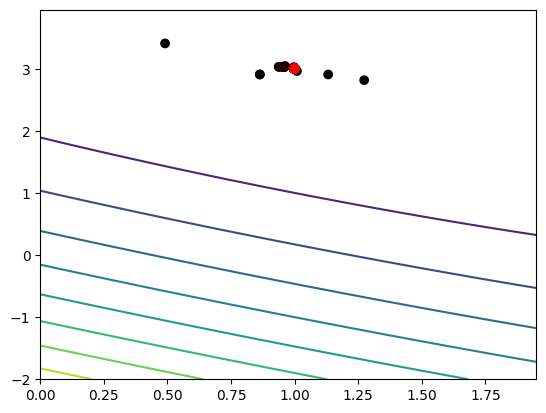

In [207]:
XG_narrow = np.arange(0, 2, 0.05)
YG_narrow = np.arange(-2, 4, 0.05)
algorithm2.plot_func(algorithm2.trace, XG_narrow, YG_narrow)

# Wnioski
Podejście genetyczne w problemie minimalizacji funkcji $f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}$ daje podobną skuteczność do podejścia z wykorzystaniem metody gradientowej. Algorytm genetyczny uzyskuje rozwiązanie z błędem $\epsilon=5.854e-05$, podczas gdy algorytym gradientowy $\epsilon = 1.051e-06$.

Pierwszą zauważalną różnicą pomiędzy algorytem genetycznym, a gradientowym jest fakt losowości. W pierwszym przypadku mamy wiele zmiennych losowych takich jak liczba krzyżowań, liczba mutacji czy miejsca krzyżowań chromosomów. Wpływa to na ostateczne rozwiązanie algorytmu, które nie zawsze będzie takie samo, jak to miało miejsce w przypadku algorytmu wykorzystującego spadek gradientu, gdzie mogliśmy przewidywać, że kolejne uruchomienie algorytmu, bez zmiany parametrów, przyniesie podobny rezultat. Raz możemy uzyskać rozwiązanie rzędu $e-1$, a innym razem rzędu $e-6$.

Interesującą rzeczą jest także sprawa wielkości chromosomu, która w ogólności powinna sprzyjać dokładności rozwiazania, natomiast w przypadku naszej funkcji, posiadającej minimum w punkcie $(0, 0)$ to chromosomy o mniejszej ilości genów kodujących argumenty funkcji będzie powodowała lepsze rozwiązanie. Przyczyna takiego działania jest bardzo prosta, im mniej bitów tym mniej możliwości reprezentacji mamy, posiadamy mniejszą rozdzielczość i gdy rozwiązanie jest w punkcie $(0, 0)$ to chromosom o 4 bitach (po 2 bity na każdy argument) najszybciej dostarczy najlepsze rozwiazanie, ponieważ w przykładowej populacji 1000 osobników mamy prawdopodobieństwo bliskie pewności, że wystąpi osobnik z chromosomem o genach [0, 0, 0, 0] (po przemapowaniu na nowy zakres). Natomiast w ogólności im więcej bitów poświęcimy na geny tym lepsze rozwiązanie powinniśmy uzyskać, co dowodzi przykład minimalizacji funkcji $g(x) = (x_1 + 2*x_2 - 7)**2 + (2*x_1 + x_2 - 5)**2$, gdzie przy parametrach:
- chromosome length: 48
- population size: 1000
- number of steps: 100
- mutation probability: 0.25
- crossover probability: 0.8

uzyskujemy rozwiązanie z błędem równym $\epsilon=5.116e-13$